In [1]:
from utils.common_imports import *
from IPython.display import display

# Get a annotation:
all_annotations: list[pl.Annotation] = pl.query(pl.Annotation).all()

In [2]:
def get_roi_slices(ann: pl.Annotation, padding: int = 50) -> tuple[np.ndarray, np.ndarray]:
    """Given a annotation, returns a padded ROI volume and the dimensions of the bounding box of the ROI in the full scan."""
    vol = ann.scan.to_volume(verbose=False)
    roi_scan_bbox = ann.bbox()
    padded_roi_bbox = ann.bbox(pad=padding)
    return vol[padded_roi_bbox], roi_scan_bbox, padded_roi_bbox


def visualise_roi(ann: pl.Annotation, padding: int = 50, n_append: int = 5, show_contours: bool = True) -> None:
    # Annotated slices
    # TODO add all other annotations for the same nodule
    ann_scan_slice_idxs = ann.contour_slice_indices
    ann_scan_slice_start_idx = int(ann_scan_slice_idxs[0])
    ann_scan_slice_end_idx = int(ann_scan_slice_idxs[-1])

    # get the ROI and its bounding box in the scan
    roi, roi_scan_bbox, padded_roi_scan_bbox = get_roi_slices(ann, padding=padding)

    # Subset the scans in the ROI that are annotated
    pad_slice_min = padded_roi_scan_bbox[-1].start
    pad_slice_max = padded_roi_scan_bbox[-1].stop
    lower_bound = ann_scan_slice_start_idx - pad_slice_min
    upper_bound = pad_slice_max - ann_scan_slice_end_idx
    roi_annotated_subset = roi[:, :, lower_bound:-upper_bound + 1]

    assert roi_annotated_subset.shape[-1] == len(ann_scan_slice_idxs), "The number of annotated slices in the ROI does not match the number of annotated slices in the annotation."

    # Append n_append equally spaced slices before and after the annotated slices
    front_append_slice_idxs = np.linspace(start=0, stop=lower_bound, num=n_append, dtype=int)
    back_append_slice_idxs = np.linspace(start=upper_bound, stop=roi.shape[-1] - 1, num=n_append, dtype=int)
    roi_concat = np.concatenate([roi[:,:,front_append_slice_idxs], roi_annotated_subset, roi[:,:,back_append_slice_idxs]], axis=-1)

    # Now display the slices in @roi_concat
    annotated_start_idx = n_append
    annotated_end_idx = n_append + len(ann_scan_slice_idxs)

    n_slices = roi_concat.shape[-1]
    n_cols = 4
    n_rows = (n_slices + n_cols -1) // n_cols

    # for rescaling of the contours to match the crop:
    padded_roi_bbox_x_min = int(padded_roi_scan_bbox[1].start)
    padded_roi_bbox_y_min = int(padded_roi_scan_bbox[0].start)

    malignancy_desc = ["Highly Unlikely",
    "Moderately Unlikely",
    "Indeterminate",
    "Moderately Suspicious",
    "Highly Suspicious"]

    # Plot figure:
    all_contours = ann.contours
    _, axs = plt.subplots(n_rows, n_cols, figsize=(10,6))
    for i in range(n_slices):
        ax = axs[i//n_cols, i%n_cols]
        ax.imshow(roi_concat[:,:,i], cmap='gray')

        if annotated_start_idx <= i < annotated_end_idx and show_contours:
            # if the image is an annotated slice, plot the contours
            ax.set_title(f"Annotated. Malignancy: ({ann.malignancy}) {malignancy_desc[ann.malignancy - 1]}")
            con = all_contours[i - annotated_start_idx]
            ii, jj = con.to_matrix(include_k=False).T
            # Rescale the contours to match the crop:
            jj = jj - padded_roi_bbox_x_min
            ii = ii - padded_roi_bbox_y_min
            ax.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")

        else:
            # ax.set_title(f"Not Annotated")
            ax.axis('off')
            continue
        ax.axis('off')

    plt.suptitle(f"Annotation ID: {ann.id} - scan ID: {ann.scan.id} - padding: {padding}")
    plt.tight_layout()
    plt.show()

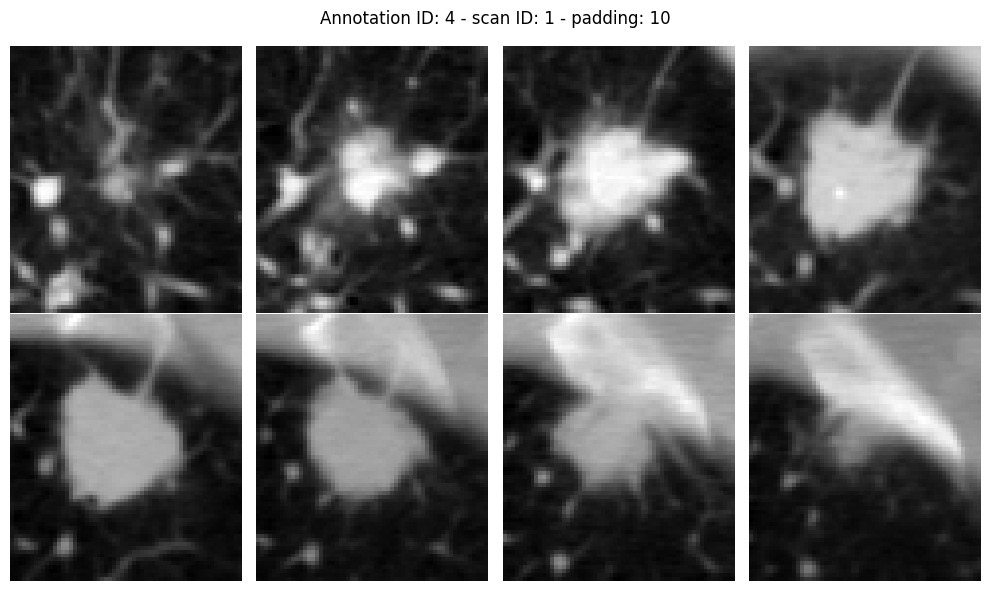

In [5]:
ann = all_annotations[3]
visualise_roi(ann, padding=10, n_append=0, show_contours=False)

Loading dicom files ... This may take a moment.


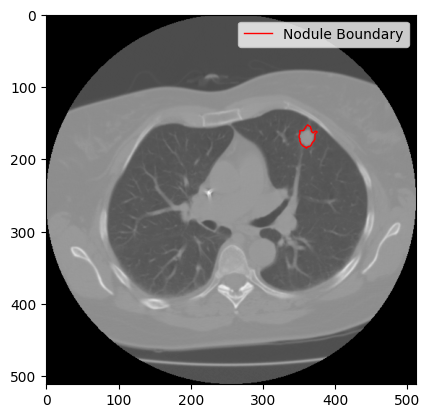

In [3]:
ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")
plt.legend()
plt.show()